# Checkpoint 5

## Problem 1
Create two classes, one called Linear (to model the background distribution), and a
second one called Gaussian (to model the signal distribution). For both of them add an
attribute mass array (to be initialised in the constructor) to hold the mass values that
will make up the spectrum of the background and signal distributions. Add also a next()
member function to be used for drawing random x-values (ie. corresponding to the mass)
according to the parent f(x) distribution. For class Gaussian use the built-in method
numpy.random.normal to draw random values. For class Linear use the “box” method
(as discussed in previous lectures)

Now create class SignalWithBackground which will return the sum of the signal (Signal)
and background (Linear) distributions weighted by the fractions of signal and back-
ground events

Now put everything together with something like the following snippet (lots of little
details omitted!), and plot the three distributions

Full problem in PDF from notes

In [1]:
import numpy as np
import scipy
from scipy import integrate
from scipy.special import erfinv
from iminuit import Minuit
import math
import matplotlib.pyplot as plt


In [2]:
# Background parameters, as defined in the problem
xmin = 0.
xmax = 20.
intercept = 20.
slope = -1.

# signal parameters
mean = 10.
sigma = 0.5

# chose number of bins that is appropriate for the size of the statistics sample
nbins = 100

In [3]:
class Linear:
    def __init__(self, mass, lower_lim, higher_lim, intercept, slope):
        self.mass = mass
        self.lower_lim = lower_lim
        self.higher_lim = higher_lim
        self.intercept = intercept
        self.slope = slope
        
    # Evaluate method (unnormalised)
    def evaluate(self, x):
        return (lambda x: self.intercept + self.slope * x)(x)
    
    # Standard box method for creating the random distribution
    def next(self):
        doLoop = True
        while(doLoop):
            # start with uniform random number in [lolimit, hilimit]
            x = np.random.uniform(self.lower_lim, self.higher_lim)
            # y1 forces the linear trendline
            y1 = self.evaluate(x)
            # Create 
            y2 = np.random.uniform(0, self.higher_lim)
            if (y2 < y1):
                filtered_x = x
                self.mass.append(filtered_x)
                return filtered_x
                

    

In [4]:
class Gaussian:
    def __init__(self, mass, mean, sigma):
        self.mass = mass
        self.mean = mean
        self.sigma = sigma
        self.xmin = xmin
        self.xmax = xmax
        
    def next(self):
        # no need for box method, as np.random.normal is by default gaussian
        y1 = np.random.normal(self.mean, self.sigma)
        self.mass.append(y1)
        return y1
    
    ## Useful for function integral, returns result of gaussian function
    #def gaussian(self):
    #    
    #    return lambda x: np.exp(-np.power(x - self.mean, 2.) / (2 * np.power(self.sigma, 2.)))
    
    #    # Integral method required by Problem No.2
    #def integral(self, minim, maxim):
    #    int_val = scipy.integrate.quad(Gaussian.gaussian, minim, maxim)
    #    return int_val
        
    
    ## Integral method required by Problem No.2
    #def integral(self):
    #    int_val = scipy.integrate.quad(gaussian, self.xmin, self.xmax)
    #    return int_val
        

In [5]:
class SignalWithBackground:
    def __init__(self, mean, sigma, sig_fraction, intercept, slope, lower_lim, higher_lim):
        self.mean = mean
        self.sigma = sigma
        self.sig_fraction = sig_fraction
        self.intercept = intercept
        self.slope = slope
        self.xmin = lower_lim
        self.xmax = higher_lim
        
        # Create the mass distribution variables
        self.mass_sig = []
        self.mass_bgd = []
        self.mass = []
        
        # Create the connection variables to the Gaussian and Linear classes
        # Unsure if everything needed will be passed through? Doing it anyway
        self.background = Linear(self.mass, self.xmin, self.xmax, self.intercept, self.slope)
        self.signal = Gaussian(self.mass, self.mean, self.sigma)
    
    # Draw random number form distribution, as taken from notes
    def next(self):
        q = np.random.uniform()
        if ( q < self.sig_fraction):
            # If true, draw from signal distribution
            filtered_x = self.signal.next()
            self.mass_sig.append(filtered_x)
        else:
            # If false, draw from background distribution
            filtered_x = self.background.next()
            self.mass_bgd.append(filtered_x)
        
        # Collect both together. THIS LINE ISNT NEEDED AS ITS APPLIED WITHIN BOTH LINEAR.NEXT() AND GAUSSIAN.NEXT()
        #self.mass.append(filtered_x)
        return filtered_x
        

In [6]:
# Main code to generate and plot a single experiment
def singleToy(nevents_sig = 300, nevents_bdg = 10000):
    
    sig_fraction = nevents_sig/(nevents_bdg + nevents_sig)
    # Create the pdf using the above methods
    pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, xmin, xmax)
    
    for i in range(nevents_sig + nevents_bdg):
        pdf.next()
    
    # retrieve the mass values for signal , background and their sum
    data = pdf.mass
    sig_data = pdf.mass_sig
    bgd_data = pdf.mass_bgd
    
    # plot things on same page
    myRange = (xmin , xmax)
    fig, axs = plt.subplots(3,1, sharex='col')
    axs [0].set_title("Signal distribution (" + str(len(sig_data )) + " entries)")
    axs [1].set_title("Background distribution (" + str(len(bgd_data )) + " entries)")
    axs [2].set_title("Total distribution (" + str(len(data)) + " entries)")
    axs [2].set_xlabel('X')
    axs [0].hist(sig_data , bins=nbins , range=myRange)
    axs [1].hist(bgd_data , bins = nbins)
    axs [2].hist(data , bins = nbins)
    # Make the figures larger
    fig.set_figheight(15)
    fig.set_figwidth(10)
    fig.tight_layout()
    plt.savefig('Example1.pdf')
    plt.show()

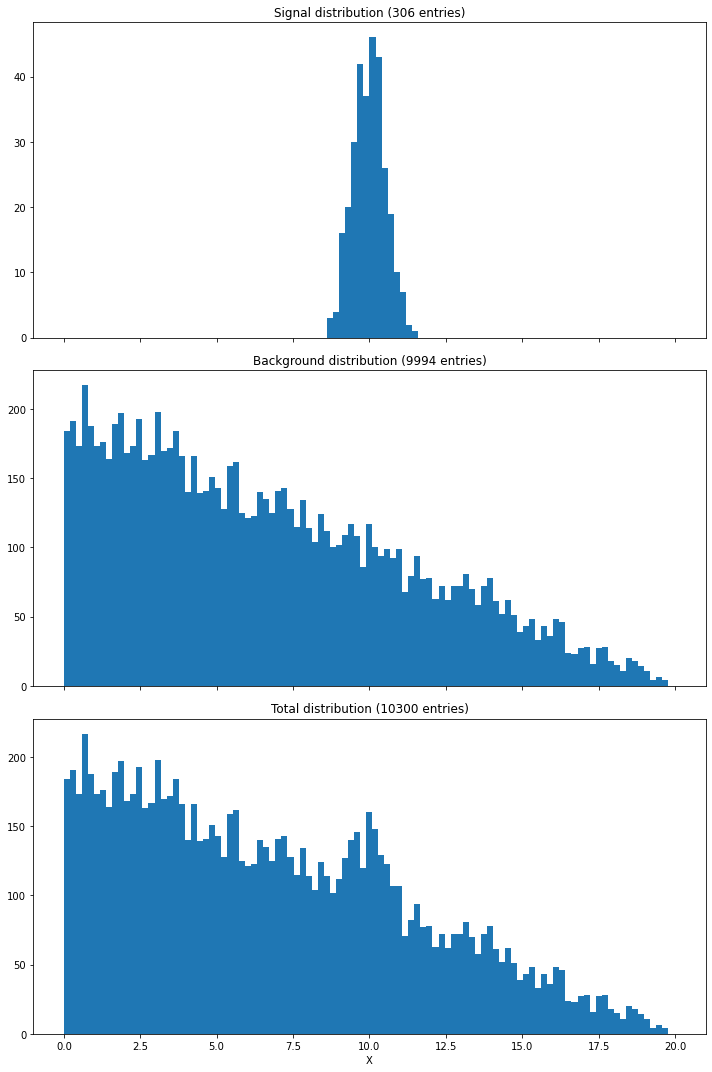

In [7]:
# Run the above code
singleToy()

Even here with approximately 300 events out of 10300, the signal can be seen at X=10 with relative certainty across multiple different random runs of singleToy(). Now lets try doubling the signal events.

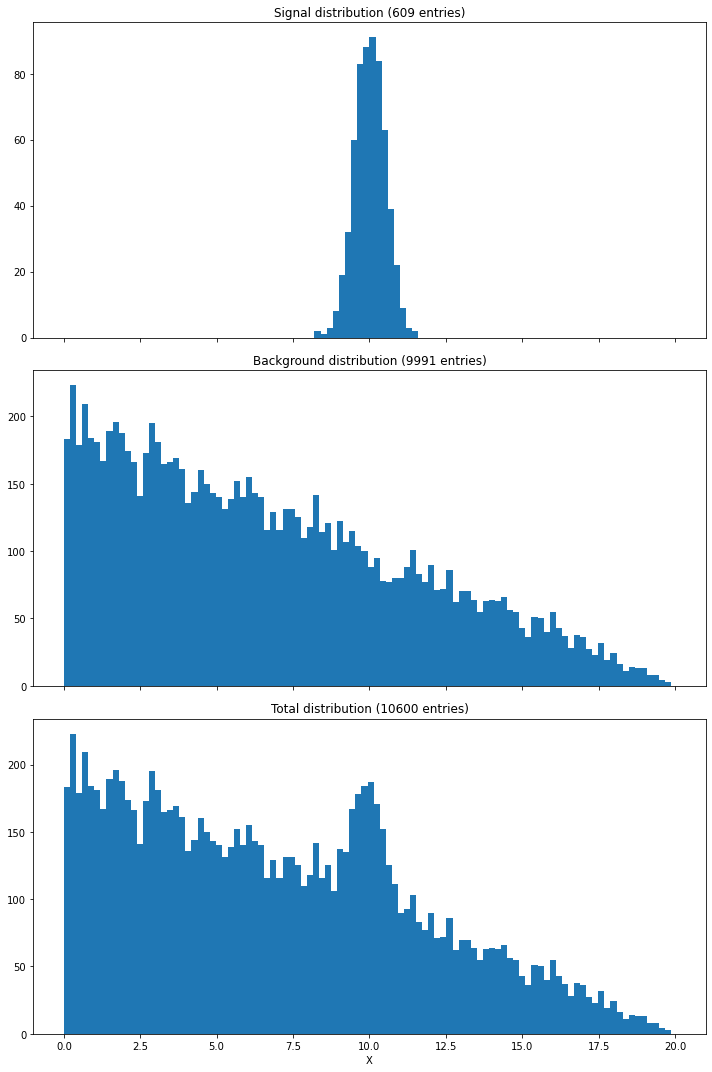

In [8]:
# Testing with double the signal events
singleToy(600, 10000)

Even just doubling the number of signal events makes the peak in the centre exceptionally prominent.
Now we'll try halving it:

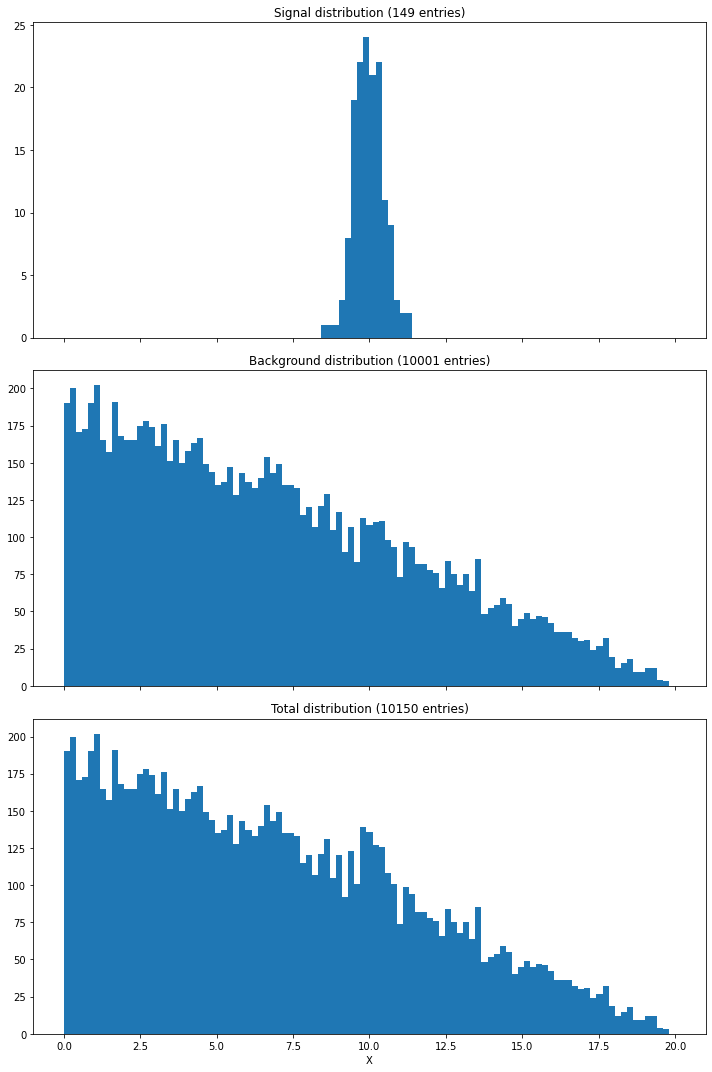

In [9]:
# Testing with halving the signal events
singleToy(150, 10000)

Almost unnoticable within the total distribution. Now onto quantifying these observations. Estimating how likely it is to get a fluctuation as the one in the our standard 300 signal events run, in the absence of a genuine signal.

## Problem 2

Calculate the probability that a background-only process with λ = 10,000 can fluctuate
to give k ≥10,300. The fastest way to do this is to employ the previously coded Gaussian
class, by adding an integral() method, which can be easily implemented with method
scipy.integrate.quad. You will need to take the ratio of two such integrals.
Calculate how large the deviation is by converting the p-value to a Z-score (or number of
standard deviations). You can use the inverse error function1, as shown in the following
snippet:

In [10]:
# Old code, ignore

#test1 = Gaussian(new_mass, new_mean, new_sigma, 0, 20000)
#for i in range(10000): 
#    test1.next()
    
## Collect the definite integrals for these ranges
#integral1 = test1.integral(0, 10000)
#integral2 = test1.integral(0, 10300)

#pvalue = integral2/integral1
#n_sigmas = erfinv(1-pvalue) * np.sqrt(2)




In [11]:
# creating new gaussian with mu=10k, sig = 100 and large limits around 10k
new_mean = 10000
new_sigma = 100
new_mass = []

# defining a simple gaussian here
# problem with this method is that I assume it has both tails? 
# Right now setting mu and sigma within definition, but seems wrong to me
def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

# Defining the method for showing P value and sigma
def p_sig(mu, sigma, limits):
    
    # Allows you to pass in your own specific limits
    limit1, limit2 = limits[0], limits[1]
    
    # calculate integral across entire gaussian
    res1, err = scipy.integrate.quad(gaussian, limit1[0], limit1[1], args = (mu, sigma))
    # calculate integral for gaussian results greater than 10300
    res2, err2 = scipy.integrate.quad(gaussian, limit2[0], limit2[1], args = (mu, sigma))

    # Calculate pvalue, and then number of sigmas
    pvalue = res2/res1
    n_sigmas = erfinv(1 - pvalue) * np.sqrt(2)
    print("P value: {:E} \nNumber of sigma for k = {:}: {:.2f}".format(pvalue, limit2[0],  n_sigmas))



In [12]:
# Find P value and sigma using above function
p_sig(new_mean, new_sigma, [[0, 20000],[10300, 20000]])

P value: 1.349898E-03 
Number of sigma for k = 10300: 3.21


## Problem 3

First, confirm that the number of (expected) background events in the 5 < x < 15
subregion is 50%. Then, calculate the p-value and the Z-score as in the previous problem
for the updated λ and k values. You will notice that the deviation is more significant
now. Why?

In [13]:
# NUMERICAL PROOF

# Can use simple list manipulation to collect background events quickly.

# pulling from singleToy from earlier
def splitToy(nevents_sig = 300, nevents_bdg = 10000):
    
    sig_fraction = nevents_sig/(nevents_bdg + nevents_sig)
    # Create the pdf using the above methods
    pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, xmin, xmax)
    
    for i in range(nevents_sig + nevents_bdg):
        pdf.next()
    
    # retrieve the background data
    bgd_data = pdf.mass_bgd
    return bgd_data


# Do it numerically with averages, should demonstrate the point
# Value wont be perfect but pretty close

init_len = []
half_len = []

# Loop to allow for increased accuracy in final result. 
for i in range(100):
    # Collect data, exclusively background events (and 10k of them)
    data = splitToy(nevents_sig = 0, nevents_bdg = 10000)
    # Collect the number of data points
    init_len.append(len(data))
    # Remove all data values < 5 and > 15
    data = [x for x in data if x > 5 and x < 15]
    # Collect the number of data points from new split data
    half_len.append(len(data))

In [14]:
# Show the averages of both
initial = np.mean(init_len)
final = np.mean(half_len)
    
print("Averaged background values: {:.2f}\nAveraged background values for x > 5, x < 15: {:.2f}".format(initial, final))

Averaged background values: 10000.00
Averaged background values for x > 5, x < 15: 5004.16


As we can see here, although not perfect (due to the randomness inherent in our method) the Averaged background values will be approximately 5000, or half the total sample size.

There are better (more analytical ways) of doing this, for example the integral over the background function (y=mx+c) divided by the integral for our selected region is an obvious one, but I found this to be the simplest way to do it numerically.

Here is the analytical way of doing it:

In [15]:
# ANALYTICAL PROOF

# Use the evaluate function within Linear class, y=mx+c
# With this, can integrate over our entire range for the initial function shape. Then again with our limits on x
# Then compare the two.

# Just to insert
fake_mass = []
# Using all the values from the initial for intercept, slow, etc
lin = Linear( fake_mass, xmin, xmax, intercept, slope)
# Find the integral for the full function from 0 -> 20
int_lin, err = scipy.integrate.quad(lin.evaluate, 0, 20)
# Find second integral with our limits
half_lin, err2 = scipy.integrate.quad(lin.evaluate, 5, 15)

print("Area of the linear function that our new subregion covers: {:.2f}%".format((half_lin/int_lin)*100))

Area of the linear function that our new subregion covers: 50.00%


As you can see here, our function now only collects half the total background events across x=5 to x=15.

Now, need to calculate the p-value and Z-score with these updated values of lambda and k

In [16]:
# Using the function from earlier p_sig
numu = 5000
sigm = math.sqrt(numu)
# Find P value and sigma using above function.
# Limits, first one defines the entire function, second only applies after 5300.
p_sig(numu, sigm, [[0, 10000],[5300, 10000]])

P value: 1.104525E-05 
Number of sigma for k = 5300: 4.40


The number of sigma is much larger now to reach the value of 5300.

That is due to the total number of events being smaller. 300/10000 is a significantly smaller variation when compared to 300/5000. So in short, 300 events now make up a significantly larger amount of the distribution and so it becomes significantly more unlikely.

In [17]:
# Old code please ignore


# Can reuse the gaussian function from earlier

# calculate integral across entire gaussian
#numu = 5000
#sigm = math.sqrt(numu)
#res3, err = scipy.integrate.quad(gaussian, 0, 10000, args = (numu, sigm))
## calculate integral for gaussian results greater than 10300
#res4, err2 = scipy.integrate.quad(gaussian, 5300, 10000, args = (numu, sigm))

## Calculate pvalue, and then number of sigmas
#pvalue = res4/res3
#n_sigmas = erfinv(1 - pvalue) * np.sqrt(2)
#print("P value: {:E} \nNumber of sigma for k = 10300 or greater: {:.2f}".format(pvalue, n_sigmas))

## Problem 4

In this example you should decrease the population of signal events to 150 (or ∼1.5%
of the total sample). Despite having a weaker signal, the shape-based analysis provides
a much more powerful statistical test than mere event-counting. You should carry out
two fits on the same “data” histogram, one assuming no signal (H0), and a second one
assuming a signal (H1) of uknown size (but with fixed mean and sigma values). In both
fits the shape of the background distribution (slope and intercept) should be free to vary.
Find the difference in the (log-likelihood-equivalent) χ2 between the H0 and H1 fits. Since
the difference in the number of degress of freedom between the two models is just one
(the size of the signal contribution), you should use this information and Wilk’s theorem
to calculate the p-value and the Z-score (method scipy.stats.chi2.cdf can be used
here).

In [39]:
# Will just adjust singleToy to give us the data rather than the plots
# Main code to generate and plot a single experiment
def singleToyData(nevents_sig = 150, nevents_bdg = 10000):
    
    sig_fraction = nevents_sig/(nevents_bdg + nevents_sig)
    # Create the pdf using the above methods
    pdf = SignalWithBackground(mean, sigma, sig_fraction, intercept, slope, xmin, xmax)
    
    for i in range(nevents_sig + nevents_bdg):
        pdf.next()
    
    # retrieve the mass values for signal , background and their sum
    data = pdf.mass
    sig_data = pdf.mass_sig
    bgd_data = pdf.mass_bgd
    return data, sig_data, bgd_data

data, sig_data, bgd_data = singleToyData(nevents_sig = 150, nevents_bdg = 10000)

# To ensure we dont get any 0 values in our data, will set them to a small value.
# This is done to avoid issues with the way we calculate chi squared later
#data = [0 if x < 0 else x for x in data]
#data = [1 if x == 0 else x for x in data]

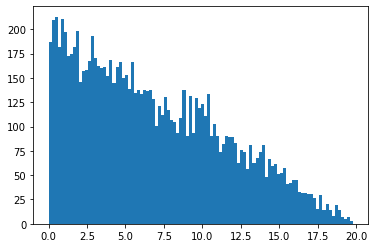

In [40]:
# Collect X and Y values for our fit:
plt.hist(data, bins = nbins)
ax = plt.gca()
p = ax.patches

# Heights -> y, bin_pos -> x
heights = [patch.get_height() for patch in p]
bin_pos = np.linspace(0, 20, nbins)

# Collecting our bin sizes and the number of events we have
widths = p[0].get_width()
event_no = len(data)

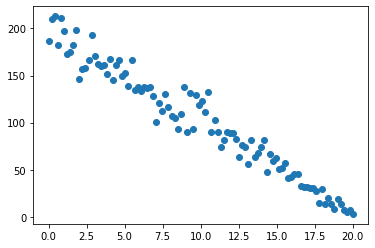

In [41]:
# Showing out XY plot for the data
plt.scatter(bin_pos, heights)
plt.show()

In [42]:
# defining a new linear function here, just for ease of use and readability
def lin(x, m, c):
    return m*x + c

## ALL COMMENTED CODE HERE SHOULD BE IGNORED, I WAS TESTING NLL BUT IT WASN'T WORKING
## CHOSE TO USE CHI SQUARED METHOD INSTEAD

#def nll(function, y, slope, intercept):
#    # integrate over our range
#    y_new, err_new = scipy.integrate.quad(function, 0, intercept, args = (slope, intercept))
#    # Normalise y values
#    y = [q / y_new for q in y]
#    ll = np.sum(np.log(y))
#    return -ll


#def nlllin(slope, intercept):
#    # integrate over our range
#    y_new, err_new = scipy.integrate.quad(lin, 0, 20, args = (slope, intercept))
#    # Normalise y values
#    y = [q / y_new for q in heights]
#    ll = np.sum(np.log(y))
#    return -ll

## Collect the negative log likelihood with this linear
#neg_ll = nlllin( slope, intercept)
#print(neg_ll)



In [43]:
##m = Minuit(nll, (lin, heights, -1, 20), name=("function", "y", "slope", "intercept"))
#
## Setting up minuit
#m = Minuit(nlllin, slope = -0.5, intercept = 15)
#m.errors = [0.5,0.5]
#m.errordef=0.5
#
#result = m.migrad()

In [44]:
# Taken from the notes from last week to show iminuit results
def showIminuitResult( paramNames, theMinuit ):
    
    #averageList = {}

    fstr = "{0:8.4f}"
    for pn in paramNames :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
        #averageList.update( { pn : [ val, err ] } )
    print('\n')

    return #averageList

#showIminuitResult(("slope", "intercept"), m)

Creating H0 (fitting for linear background)

In [64]:
# Calculating the chisquared as taken from the notes
def chisquared(slope, intercept):
    # integrate over our range
    y_new, err_new = scipy.integrate.quad(lin, 0, 20, args = (slope, intercept))
    # Find normalised pdf
    x = np.linspace(0,20,nbins)
    y_expected = [lin(x[i], slope, intercept) for i in range(nbins)]
    # Normalise y values
    y_expected = [q / y_new for q in y_expected]
    #y_expected =  [widths * event_no * y_expected]
    y_expected = [i * (widths*event_no) for i in y_expected]
    # Nobserved --> the y value 
    y_observed = heights
    
    
    # Finding our chi squared value
    chisum = 0
    for i in range(len(heights)):
        chisum += y_expected[i] - y_observed[i] + y_observed[i]*np.log(y_observed[i] / y_expected[i])
    chisqr = chisum*2
    return chisqr




In [65]:
# Setting up minuit
n = Minuit(chisquared, slope = -0.5, intercept = 15)
n.errors = [0.5,0.5]
n.errordef=0.5

result = n.migrad()

showIminuitResult(("slope", "intercept"), n)


	 slope           :  	  -0.4988  +/-    0.0301
	 intercept       :  	  10.1557  +/-    0.6136




In [66]:
# Chi squared for our value
print("Our chi squared value is {:.2f}".format(n.fval))
print("The number of bins we have is {}".format(nbins))

Our chi squared value is 144.24
The number of bins we have is 100


Our chi squared value is not too bad considering our degrees of freedom in each bin.

Now onto H1.

In [92]:
# Calculating the chisquared as taken from the notes
def chisquaredgauss(slope, intercept, F):
    # fixed mean and sigma values
    mu, sigma = 10, 0.5
    # integrate over our range for our gaussian
    yg_new, err_new = scipy.integrate.quad(gaussian, 0, 20, args = (mu, sigma))
    
    # Find normalised pdf
    x = np.linspace(0,20,nbins)
    yg_expected = [gaussian(x[i], mean, sigma) for i in range(nbins)]
    yg_expected = [q * 1/np.sqrt(2*np.pi*sigma**2) for q in yg_expected]
    #yg_expected = [q / yg_new for q in yg_expected]
    yg_expected = [i * (widths*event_no) for i in yg_expected]
    
    # integrate over our range for the linear
    y_new, err_new = scipy.integrate.quad(lin, 0, 20, args = (slope, intercept))
    
    # Find normalised pdf
    y_expected = [lin(x[i], slope, intercept) for i in range(nbins)]
    # Normalise y values
    y_expected = [q / y_new for q in y_expected]
    
    # Nexpected --> normalised(PDF) * bin width * total no of events
    
    #y_expected =  [widths * event_no * y_expected]
    y_expected = [i * (widths*event_no) for i in y_expected]
    
    # Collect the PDF 
    #joint1 = (y_expected * F) + yg_expected * (1-F)
    joint1 = [i * F for i in yg_expected]
    joint2 = [i * (1-F) for i in y_expected]
    joint = [sum(x) for x in zip(joint1, joint2)]
    # Nobserved --> the y value 
    y_observed = heights
    
    # Finding our chi squared value
    chisum = 0
    for i in range(len(heights)):
        chisum += joint[i] - y_observed[i] + y_observed[i]*np.log(y_observed[i] / joint[i])
    chisqr = chisum*2
    return chisqr



In [93]:
# Setting up minuit
o = Minuit(chisquaredgauss, slope = -0.5, intercept = 15, F=0.04)
o.errors = [1,1,1]
o.errordef=1

result = o.migrad()

showIminuitResult(("slope", "intercept", "F"), o)

	 slope           :  	  -0.4970  +/-    0.0443
	 intercept       :  	  10.1194  +/-    0.9017
	 F               :  	   0.0138  +/-    0.0033




In [94]:
# Chi squared for our value
print("Our chi squared value is {:.2f}".format(o.fval))
print("The number of bins we have is {}".format(nbins))

Our chi squared value is 125.49
The number of bins we have is 100


In [95]:
# Calculating the difference
print("Different in Chi squared: {:.2f}".format(n.fval - o.fval))

Different in Chi squared: 18.75


Our chi squared value is now lower than before. You may get values of slope and intercept that aren't exactly what was implemented before (-1, 20). This is because the PDF was normalised, so they should still be accurate in terms of their ratio.

-0.4988
10.1557


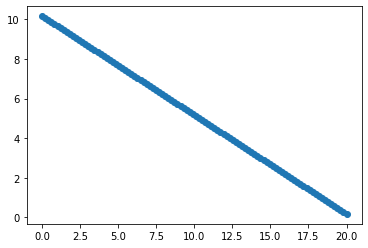

In [107]:
# plot linear fit to show that it doesnt go below zero.
# from the iminuit visualisation function from above
values = n.values
fstr = "{0:8.4f}"
print(float(fstr.format(values[0])))
print(float(fstr.format(values[1])))
mf = float(fstr.format(values[0]))
interceptf = float(fstr.format(values[1]))

# Plotting
linear_fit = []
x = np.linspace(0,20,nbins)
for i in range(nbins):
    linear_fit.append(lin(x[i], mf, interceptf))
    
plt.scatter(x,linear_fit)
plt.show()

As we can see here, our value doesnt go below zero for our linear fit.

We know that with wilkes theorem the log likelihood ratio approaches the chi squared distribution asymptotically.

In [113]:
from scipy import stats
# Finding the p value and z score
dof = 1
chi_squared_diff = n.fval - o.fval
# take the chi2.cdf to find the probability that one dof creates a difference in chi_squared that we get
pval = 1-stats.chi2.cdf(chi_squared_diff, dof)
n_sigmas = erfinv(1 - pval) * np.sqrt(2)
print("P value: {:E}\nZ value: {:.2f}".format(pval, n_sigmas))

P value: 1.492714E-05
Z value: 4.33


This means that having a scenario where our increased parameter model fits better to the extent it does it exceedingly rare. This allows us to determine that our distribution is better explained with the inclusion of our gaussian function.

So even though we can barely see by eye that the gaussian function is within the data distribution. Using this method, we can determine that such a occurence does exist within the data.